In [24]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
# for data scaling and splitting
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
# for neural net
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import regularizers
# for evaluation
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
# data plotting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
data = pd.read_csv("data/combined_expression.csv")
data['cluster'].replace([1, 2],[0, 1],inplace=True)
data.head()

,CELL_LINE_NAME,cluster,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,...,C6orf10,TMEM225,NOTCH4,PBX2,AGER,RNF5,AGPAT1,DFNB59,PRRT1,FKBPL
0,1240123,1,8.319417,3.111183,9.643558,4.757258,3.919757,3.602185,3.329644,9.076950,...,3.085394,3.462811,3.339030,4.614897,3.395845,3.419193,3.971646,3.729310,3.320022,6.447316
1,1240131,0,7.611268,2.704739,10.276079,3.650299,3.481567,3.145538,3.565127,7.861068,...,2.801456,2.985889,3.180068,5.415729,3.299858,3.028414,3.877889,3.911516,3.379405,4.729557
2,1240132,0,7.678658,2.845781,10.180954,3.573048,3.431235,3.090781,4.116643,8.121190,...,2.934962,2.952937,3.164655,5.707506,3.434295,2.961345,4.272194,3.085696,3.002557,5.653588
3,1240134,0,3.265063,3.063746,10.490285,3.340791,3.676912,3.512821,3.873922,8.790851,...,3.041839,3.398847,3.106710,5.773963,3.412641,3.136110,4.422262,3.522122,3.509437,5.953242
4,1240140,0,7.090138,2.988043,10.264692,4.119555,3.432585,3.308033,3.318371,6.927761,...,3.028787,3.225982,3.275820,5.334283,3.864678,3.259242,3.840581,5.809553,3.674587,5.577503


In [26]:
data.shape

(541, 16384)

In [27]:
selected_genes = pd.read_csv('cleaned/boruta.csv')
selected_genes = selected_genes.values.tolist()
selected_genes = list(itertools.chain(*selected_genes))

In [28]:
# retrieving proper columns
X = data.loc[:, selected_genes]
y = data['cluster'].values
# scaling the data
scalar = MinMaxScaler()
x_scaled = scalar.fit_transform(X)
# splitting data (20% test, 80% train)
X_train, X_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2)
sm = SMOTE()
X_train, y_train = sm.fit_sample(X_train, y_train)

# K-Folds Evaluation Function

In [29]:
def cv_eval(model, n_folds, X, y):
    """K-fold validation function for evaluation of a Keras model.
    Arguments:
        model: the model to evaluate.
        n_folds (int): the number of cross-folds.
        X: values of the feature variables.
        y: values of the classification.
    Returns:
        cms (list): confusion matrix for each cross-fold.
        histories (list): model metrics for each cross-fold.
        tprs (list): the True Positive Rate for each cross-fold.
        base_fpr (list): the cutoff points for the ROC curve.
    """
    kf = KFold(n_splits=n_folds)
    cms = []  # confusion matrix results
    histories = []  # for model analysis
    tprs = []  # for ROC analysis
    base_fpr = np.linspace(0, 1, 101)  # for ROC analysis

    for i_train, i_test in kf.split(X, y):
        X_train, X_test = X.iloc[i_train].values, X.iloc[i_test].values
        y_train, y_test = y[i_train], y[i_test]
        # recording model metrics and confusion matrix
        histories.append(model.fit(X_train, y_train, validation_data=(X_test, y_test)))
        cms.append(confusion_matrix(y_test, model.predict(X_test)))
        # recording for auc
        y_score = model.predict_proba(X_test)
        fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
        tpr = np.interp(base_fpr, fpr, tpr)
        tpr[0] = 0.
        tprs.append(tpr)

    return cms, histories, tprs, base_fpr

# Confusion Matrix Plotting Function

In [30]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True, cbar=True):
    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    fig = plt.figure(figsize=(4, 3), dpi=200)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names, rotation=90, verticalalignment='center')
#         plt.yticks([], ['', ''])

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    if cbar:
        plt.colorbar()

    plt.tight_layout()
    plt.ylabel('True')
    plt.xlabel('Predicted\naccuracy={:0.3f}; misclass={:0.3f}'.format(accuracy, misclass))
    plt.show()

    return fig

# 1 Hidden Layer

In [31]:
def hidden1(optimizer='sgd', init='normal', dropout=0.3, neurons=100):
    model = Sequential()
    # hidden layer
    model.add(Dense(neurons, activation='relu',
                    kernel_regularizer=regularizers.l2(1e-2)
                   ))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    # output layer
    model.add(Dense(1, activation='sigmoid'))
    # compiling
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [32]:
model1 = KerasClassifier(build_fn=hidden1, epochs=25, batch_size=16)
cm_results1, history1, tpr1, base_fpr1 = cv_eval(model1, 5, X, y)

Train on 432 samples, validate on 109 samples
Epoch 1/25
432/432 [==============================] - 2s 4ms/sample - loss: 2.0462 - accuracy: 0.7708 - val_loss: 2.5743 - val_accuracy: 0.7064
Epoch 2/25
432/432 [==============================] - 0s 455us/sample - loss: 1.9223 - accuracy: 0.8333 - val_loss: 1.6714 - val_accuracy: 0.9541
Epoch 3/25
432/432 [==============================] - 0s 501us/sample - loss: 1.9201 - accuracy: 0.8264 - val_loss: 1.7208 - val_accuracy: 0.8716
Epoch 4/25
432/432 [==============================] - 0s 448us/sample - loss: 1.8896 - accuracy: 0.8241 - val_loss: 1.6890 - val_accuracy: 0.9083
Epoch 5/25
432/432 [==============================] - 0s 471us/sample - loss: 1.8588 - accuracy: 0.8472 - val_loss: 1.7107 - val_accuracy: 0.8899
Epoch 6/25
432/432 [==============================] - 0s 447us/sample - loss: 1.8191 - accuracy: 0.8565 - val_loss: 1.8528 - val_accuracy: 0.7523
Epoch 7/25
432/432 [==============================] - 0s 438us/sample - loss: 1.

Epoch 6/25
433/433 [==============================] - 0s 552us/sample - loss: 1.7501 - accuracy: 0.8845 - val_loss: 1.9373 - val_accuracy: 0.8241
Epoch 7/25
433/433 [==============================] - 0s 568us/sample - loss: 1.7539 - accuracy: 0.8637 - val_loss: 1.8940 - val_accuracy: 0.8241
Epoch 8/25
433/433 [==============================] - 0s 607us/sample - loss: 1.7200 - accuracy: 0.8661 - val_loss: 1.8667 - val_accuracy: 0.8148
Epoch 9/25
433/433 [==============================] - 0s 581us/sample - loss: 1.6943 - accuracy: 0.8868 - val_loss: 1.8417 - val_accuracy: 0.8333
Epoch 10/25
433/433 [==============================] - 0s 619us/sample - loss: 1.6567 - accuracy: 0.8822 - val_loss: 1.8583 - val_accuracy: 0.8333
Epoch 11/25
433/433 [==============================] - 0s 612us/sample - loss: 1.6651 - accuracy: 0.8614 - val_loss: 1.8370 - val_accuracy: 0.8148
Epoch 12/25
433/433 [==============================] - 0s 573us/sample - loss: 1.6329 - accuracy: 0.8822 - val_loss: 1.821

433/433 [==============================] - 0s 569us/sample - loss: 1.6839 - accuracy: 0.8776 - val_loss: 1.7359 - val_accuracy: 0.8148
Epoch 12/25
433/433 [==============================] - 0s 592us/sample - loss: 1.6703 - accuracy: 0.8568 - val_loss: 1.7624 - val_accuracy: 0.7870
Epoch 13/25
433/433 [==============================] - 0s 633us/sample - loss: 1.6392 - accuracy: 0.8637 - val_loss: 1.8375 - val_accuracy: 0.7500
Epoch 14/25
433/433 [==============================] - 0s 620us/sample - loss: 1.5984 - accuracy: 0.8776 - val_loss: 1.6727 - val_accuracy: 0.8148
Epoch 15/25
433/433 [==============================] - 0s 625us/sample - loss: 1.5858 - accuracy: 0.8868 - val_loss: 1.7143 - val_accuracy: 0.7963
Epoch 16/25
433/433 [==============================] - 0s 612us/sample - loss: 1.5731 - accuracy: 0.8868 - val_loss: 1.6940 - val_accuracy: 0.7963
Epoch 17/25
433/433 [==============================] - 0s 639us/sample - loss: 1.5630 - accuracy: 0.8684 - val_loss: 1.6095 - val_

In [33]:
cm1 = [[0, 0]]
k, l = 0, 0
for i in cm_results1:
    for j in cm_results1[0]:
        cm1[k][l] += j
        l = (l+1) % 2
    j = (j+1) % 2
cm1 = np.array(cm1[0])

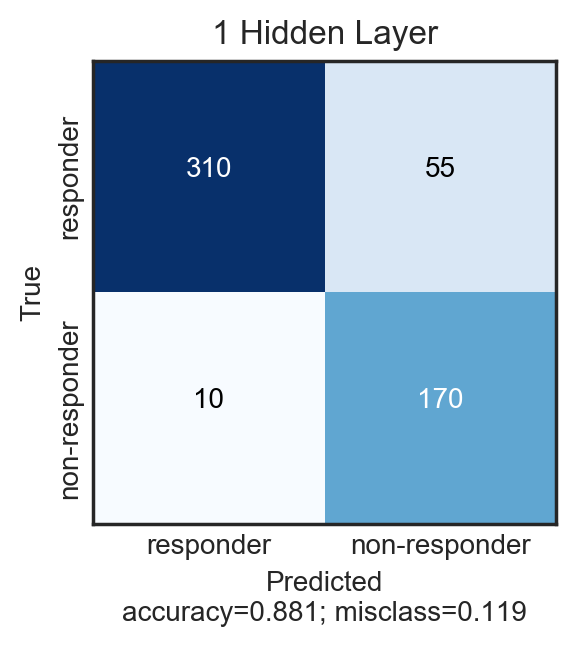

In [34]:
plt.rcParams.update({'font.size': 10})
cm_hidden1 = plot_confusion_matrix(cm1, ['responder', 'non-responder'], title='1 Hidden Layer', normalize=False, cbar=False)

# 5-Fold Validation for 5 Hidden Layers

In [35]:
def hidden5(optimizer='sgd', init='normal', dropout=0.3, neurons=100):
    model = Sequential()
    hidden_layers = len(selected_genes)
    # add 5 hidden layers
    for i in range(5):
        model.add(Dense(neurons, activation='relu',
                        kernel_regularizer=regularizers.l2(1e-2)
                       ))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

    model.add(Dense(1, activation='sigmoid'))
    # compiling
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [36]:
model5 = KerasClassifier(build_fn=hidden5, epochs=25, batch_size=16)
cm_results5, history5, tprs5, base_fpr5 = cv_eval(model5, 5, X, y)

Train on 432 samples, validate on 109 samples
Epoch 1/25
432/432 [==============================] - 6s 13ms/sample - loss: 6.2821 - accuracy: 0.6019 - val_loss: 7.4445 - val_accuracy: 0.3303
Epoch 2/25
432/432 [==============================] - 0s 1ms/sample - loss: 6.0374 - accuracy: 0.7361 - val_loss: 5.7950 - val_accuracy: 0.8991
Epoch 3/25
432/432 [==============================] - 1s 1ms/sample - loss: 5.9542 - accuracy: 0.7500 - val_loss: 5.9799 - val_accuracy: 0.6055
Epoch 4/25
432/432 [==============================] - 0s 1ms/sample - loss: 5.8545 - accuracy: 0.7778 - val_loss: 5.7210 - val_accuracy: 0.9083
Epoch 5/25
432/432 [==============================] - 1s 1ms/sample - loss: 5.8185 - accuracy: 0.7454 - val_loss: 5.7887 - val_accuracy: 0.8073
Epoch 6/25
432/432 [==============================] - 0s 1ms/sample - loss: 5.7707 - accuracy: 0.7546 - val_loss: 5.5436 - val_accuracy: 0.8440
Epoch 7/25
432/432 [==============================] - 1s 1ms/sample - loss: 5.6762 - accu

Epoch 7/25
433/433 [==============================] - 1s 1ms/sample - loss: 5.6610 - accuracy: 0.8129 - val_loss: 5.7014 - val_accuracy: 0.8148
Epoch 8/25
433/433 [==============================] - 1s 1ms/sample - loss: 5.5926 - accuracy: 0.8083 - val_loss: 5.5989 - val_accuracy: 0.8241
Epoch 9/25
433/433 [==============================] - 1s 1ms/sample - loss: 5.5235 - accuracy: 0.8360 - val_loss: 5.5532 - val_accuracy: 0.8241
Epoch 10/25
433/433 [==============================] - 1s 1ms/sample - loss: 5.4787 - accuracy: 0.8314 - val_loss: 5.5165 - val_accuracy: 0.8333
Epoch 11/25
433/433 [==============================] - 1s 1ms/sample - loss: 5.3681 - accuracy: 0.8291 - val_loss: 5.4679 - val_accuracy: 0.8333
Epoch 12/25
433/433 [==============================] - 1s 1ms/sample - loss: 5.3351 - accuracy: 0.8268 - val_loss: 5.3888 - val_accuracy: 0.8333
Epoch 13/25
433/433 [==============================] - 1s 1ms/sample - loss: 5.2741 - accuracy: 0.8568 - val_loss: 5.3267 - val_accur

Epoch 13/25
433/433 [==============================] - 1s 1ms/sample - loss: 5.2799 - accuracy: 0.8314 - val_loss: 5.1382 - val_accuracy: 0.8333
Epoch 14/25
433/433 [==============================] - 0s 1ms/sample - loss: 5.1694 - accuracy: 0.8337 - val_loss: 5.0813 - val_accuracy: 0.8333
Epoch 15/25
433/433 [==============================] - 0s 1ms/sample - loss: 5.1302 - accuracy: 0.8222 - val_loss: 5.0286 - val_accuracy: 0.8519
Epoch 16/25
433/433 [==============================] - 0s 1ms/sample - loss: 5.0338 - accuracy: 0.8614 - val_loss: 5.0448 - val_accuracy: 0.8148
Epoch 17/25
433/433 [==============================] - 1s 1ms/sample - loss: 4.9844 - accuracy: 0.8684 - val_loss: 4.9646 - val_accuracy: 0.8241
Epoch 18/25
433/433 [==============================] - 1s 1ms/sample - loss: 4.9539 - accuracy: 0.8360 - val_loss: 4.9125 - val_accuracy: 0.8333
Epoch 19/25
433/433 [==============================] - 1s 1ms/sample - loss: 4.8520 - accuracy: 0.8568 - val_loss: 4.8746 - val_ac

In [37]:
cm5 = [[0, 0]]
k, l = 0, 0
for i in cm_results5:
    for j in cm_results5[0]:
        cm5[k][l] += j
        l = (l+1) % 2
    j = (j+1) % 2
cm5 = np.array(cm5[0])

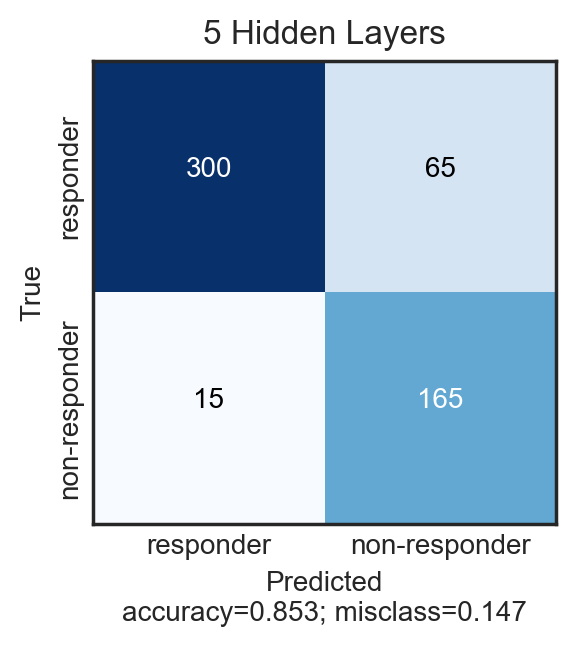

In [38]:
cm_hidden5 = plot_confusion_matrix(cm5, ['responder', 'non-responder'], title='5 Hidden Layers', normalize=False, cbar=False)

# 10 Hidden Layers

In [39]:
def hidden10(optimizer='sgd', init='normal', dropout=0.3, neurons=100):
    model = Sequential()
    hidden_layers = len(selected_genes)
    # add 10 hidden layers
    for i in range(10):
        model.add(Dense(neurons, activation='relu',
                        kernel_regularizer=regularizers.l2(1e-2)
                       ))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

    model.add(Dense(1, activation='sigmoid'))
    # compiling
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [40]:
model10 = KerasClassifier(build_fn=hidden10, epochs=25, batch_size=16)
cm_results10, history10, tprs10, base_fpr10 = cv_eval(model10, 5, X, y)

Train on 432 samples, validate on 109 samples
Epoch 1/25
432/432 [==============================] - 9s 22ms/sample - loss: 11.5862 - accuracy: 0.5185 - val_loss: 11.3060 - val_accuracy: 0.6697
Epoch 2/25
432/432 [==============================] - 1s 1ms/sample - loss: 11.4865 - accuracy: 0.5486 - val_loss: 11.2612 - val_accuracy: 0.6789
Epoch 3/25
432/432 [==============================] - 1s 1ms/sample - loss: 11.3974 - accuracy: 0.5440 - val_loss: 11.2034 - val_accuracy: 0.6697
Epoch 4/25
432/432 [==============================] - 1s 1ms/sample - loss: 11.2066 - accuracy: 0.6111 - val_loss: 11.1154 - val_accuracy: 0.6697
Epoch 5/25
432/432 [==============================] - 1s 1ms/sample - loss: 11.1437 - accuracy: 0.5556 - val_loss: 11.1421 - val_accuracy: 0.2752
Epoch 6/25
432/432 [==============================] - 1s 1ms/sample - loss: 11.0003 - accuracy: 0.6458 - val_loss: 10.8655 - val_accuracy: 0.6514
Epoch 7/25
432/432 [==============================] - 1s 1ms/sample - loss: 1

433/433 [==============================] - 1s 2ms/sample - loss: 11.3502 - accuracy: 0.6212 - val_loss: 11.1586 - val_accuracy: 0.7315
Epoch 7/25
433/433 [==============================] - 1s 2ms/sample - loss: 11.1915 - accuracy: 0.6836 - val_loss: 11.0203 - val_accuracy: 0.7870
Epoch 8/25
433/433 [==============================] - 1s 2ms/sample - loss: 11.0324 - accuracy: 0.7390 - val_loss: 10.9313 - val_accuracy: 0.8148
Epoch 9/25
433/433 [==============================] - 1s 2ms/sample - loss: 10.9518 - accuracy: 0.7067 - val_loss: 10.8333 - val_accuracy: 0.8148
Epoch 10/25
433/433 [==============================] - 1s 2ms/sample - loss: 10.8235 - accuracy: 0.7344 - val_loss: 10.7036 - val_accuracy: 0.8333
Epoch 11/25
433/433 [==============================] - 1s 2ms/sample - loss: 10.6456 - accuracy: 0.7737 - val_loss: 10.6005 - val_accuracy: 0.8333
Epoch 12/25
433/433 [==============================] - 1s 2ms/sample - loss: 10.5521 - accuracy: 0.7921 - val_loss: 10.5046 - val_acc

433/433 [==============================] - 1s 2ms/sample - loss: 10.1802 - accuracy: 0.7390 - val_loss: 10.3592 - val_accuracy: 0.6111
Epoch 12/25
433/433 [==============================] - 1s 2ms/sample - loss: 10.0653 - accuracy: 0.7621 - val_loss: 10.1163 - val_accuracy: 0.7870
Epoch 13/25
433/433 [==============================] - 1s 2ms/sample - loss: 9.9364 - accuracy: 0.7621 - val_loss: 10.0873 - val_accuracy: 0.7222
Epoch 14/25
433/433 [==============================] - 1s 2ms/sample - loss: 9.7919 - accuracy: 0.8014 - val_loss: 9.9999 - val_accuracy: 0.7685
Epoch 15/25
433/433 [==============================] - 1s 2ms/sample - loss: 9.7376 - accuracy: 0.7852 - val_loss: 9.9163 - val_accuracy: 0.7593
Epoch 16/25
433/433 [==============================] - 1s 2ms/sample - loss: 9.6365 - accuracy: 0.8129 - val_loss: 9.6747 - val_accuracy: 0.7778
Epoch 17/25
433/433 [==============================] - 1s 2ms/sample - loss: 9.4835 - accuracy: 0.8014 - val_loss: 9.5415 - val_accuracy:

In [41]:
cm10 = [[0, 0]]
k, l = 0, 0
for i in cm_results10:
    for j in cm_results10[0]:
        cm10[k][l] += j
        l = (l+1) % 2
    j = (j+1) % 2
cm10 = np.array(cm10[0])
cm10

array([[365,   0],
       [ 35, 145]])

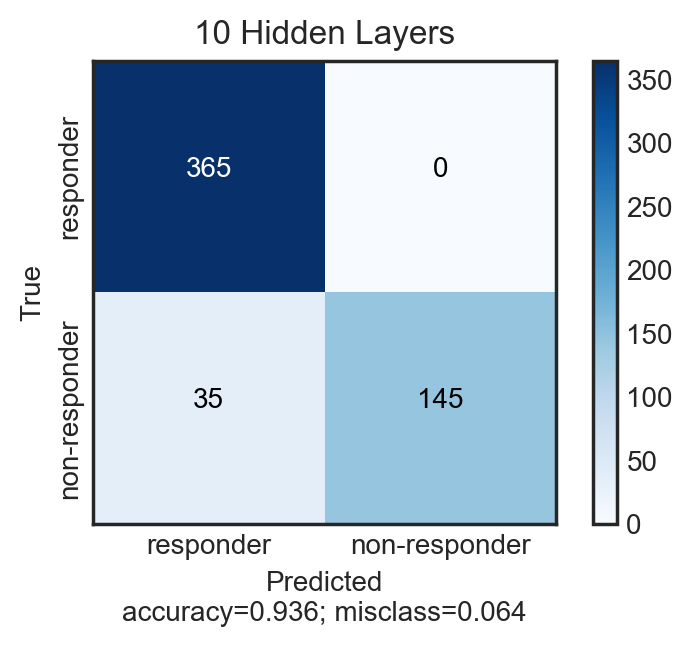

In [42]:
cm_hidden10 = plot_confusion_matrix(cm10, ['responder', 'non-responder'], title='10 Hidden Layers', normalize=False)

# Comparison Plots

In [43]:
# for 1 hidden layer
tprs1 = np.array(tpr1)
mean_tprs1 = tprs1.mean(axis=0)
std1 = tprs1.std(axis=0)
tprs_upper1 = mean_tprs1 + std1 / np.sqrt(5)
tprs_lower1 = mean_tprs1 - std1 / np.sqrt(5)
auc1 = auc(base_fpr1, mean_tprs1)

In [44]:
# for 5 hidden layers
tprs5 = np.array(tprs5)
mean_tprs5 = tprs5.mean(axis=0)
std5 = tprs5.std(axis=0)
tprs_upper5 = mean_tprs5 + std5 / np.sqrt(5)
tprs_lower5 = mean_tprs5 - std5 / np.sqrt(5)
auc5 = auc(base_fpr5, mean_tprs5)

In [45]:
# for 10 hidden layers
tprs10 = np.array(tprs10)
mean_tprs10 = tprs10.mean(axis=0)
std10 = tprs10.std(axis=0)
tprs_upper10 = mean_tprs10 + std10 / np.sqrt(5)
tprs_lower10 = mean_tprs1 - std10 / np.sqrt(5)
auc10 = auc(base_fpr10, mean_tprs10)

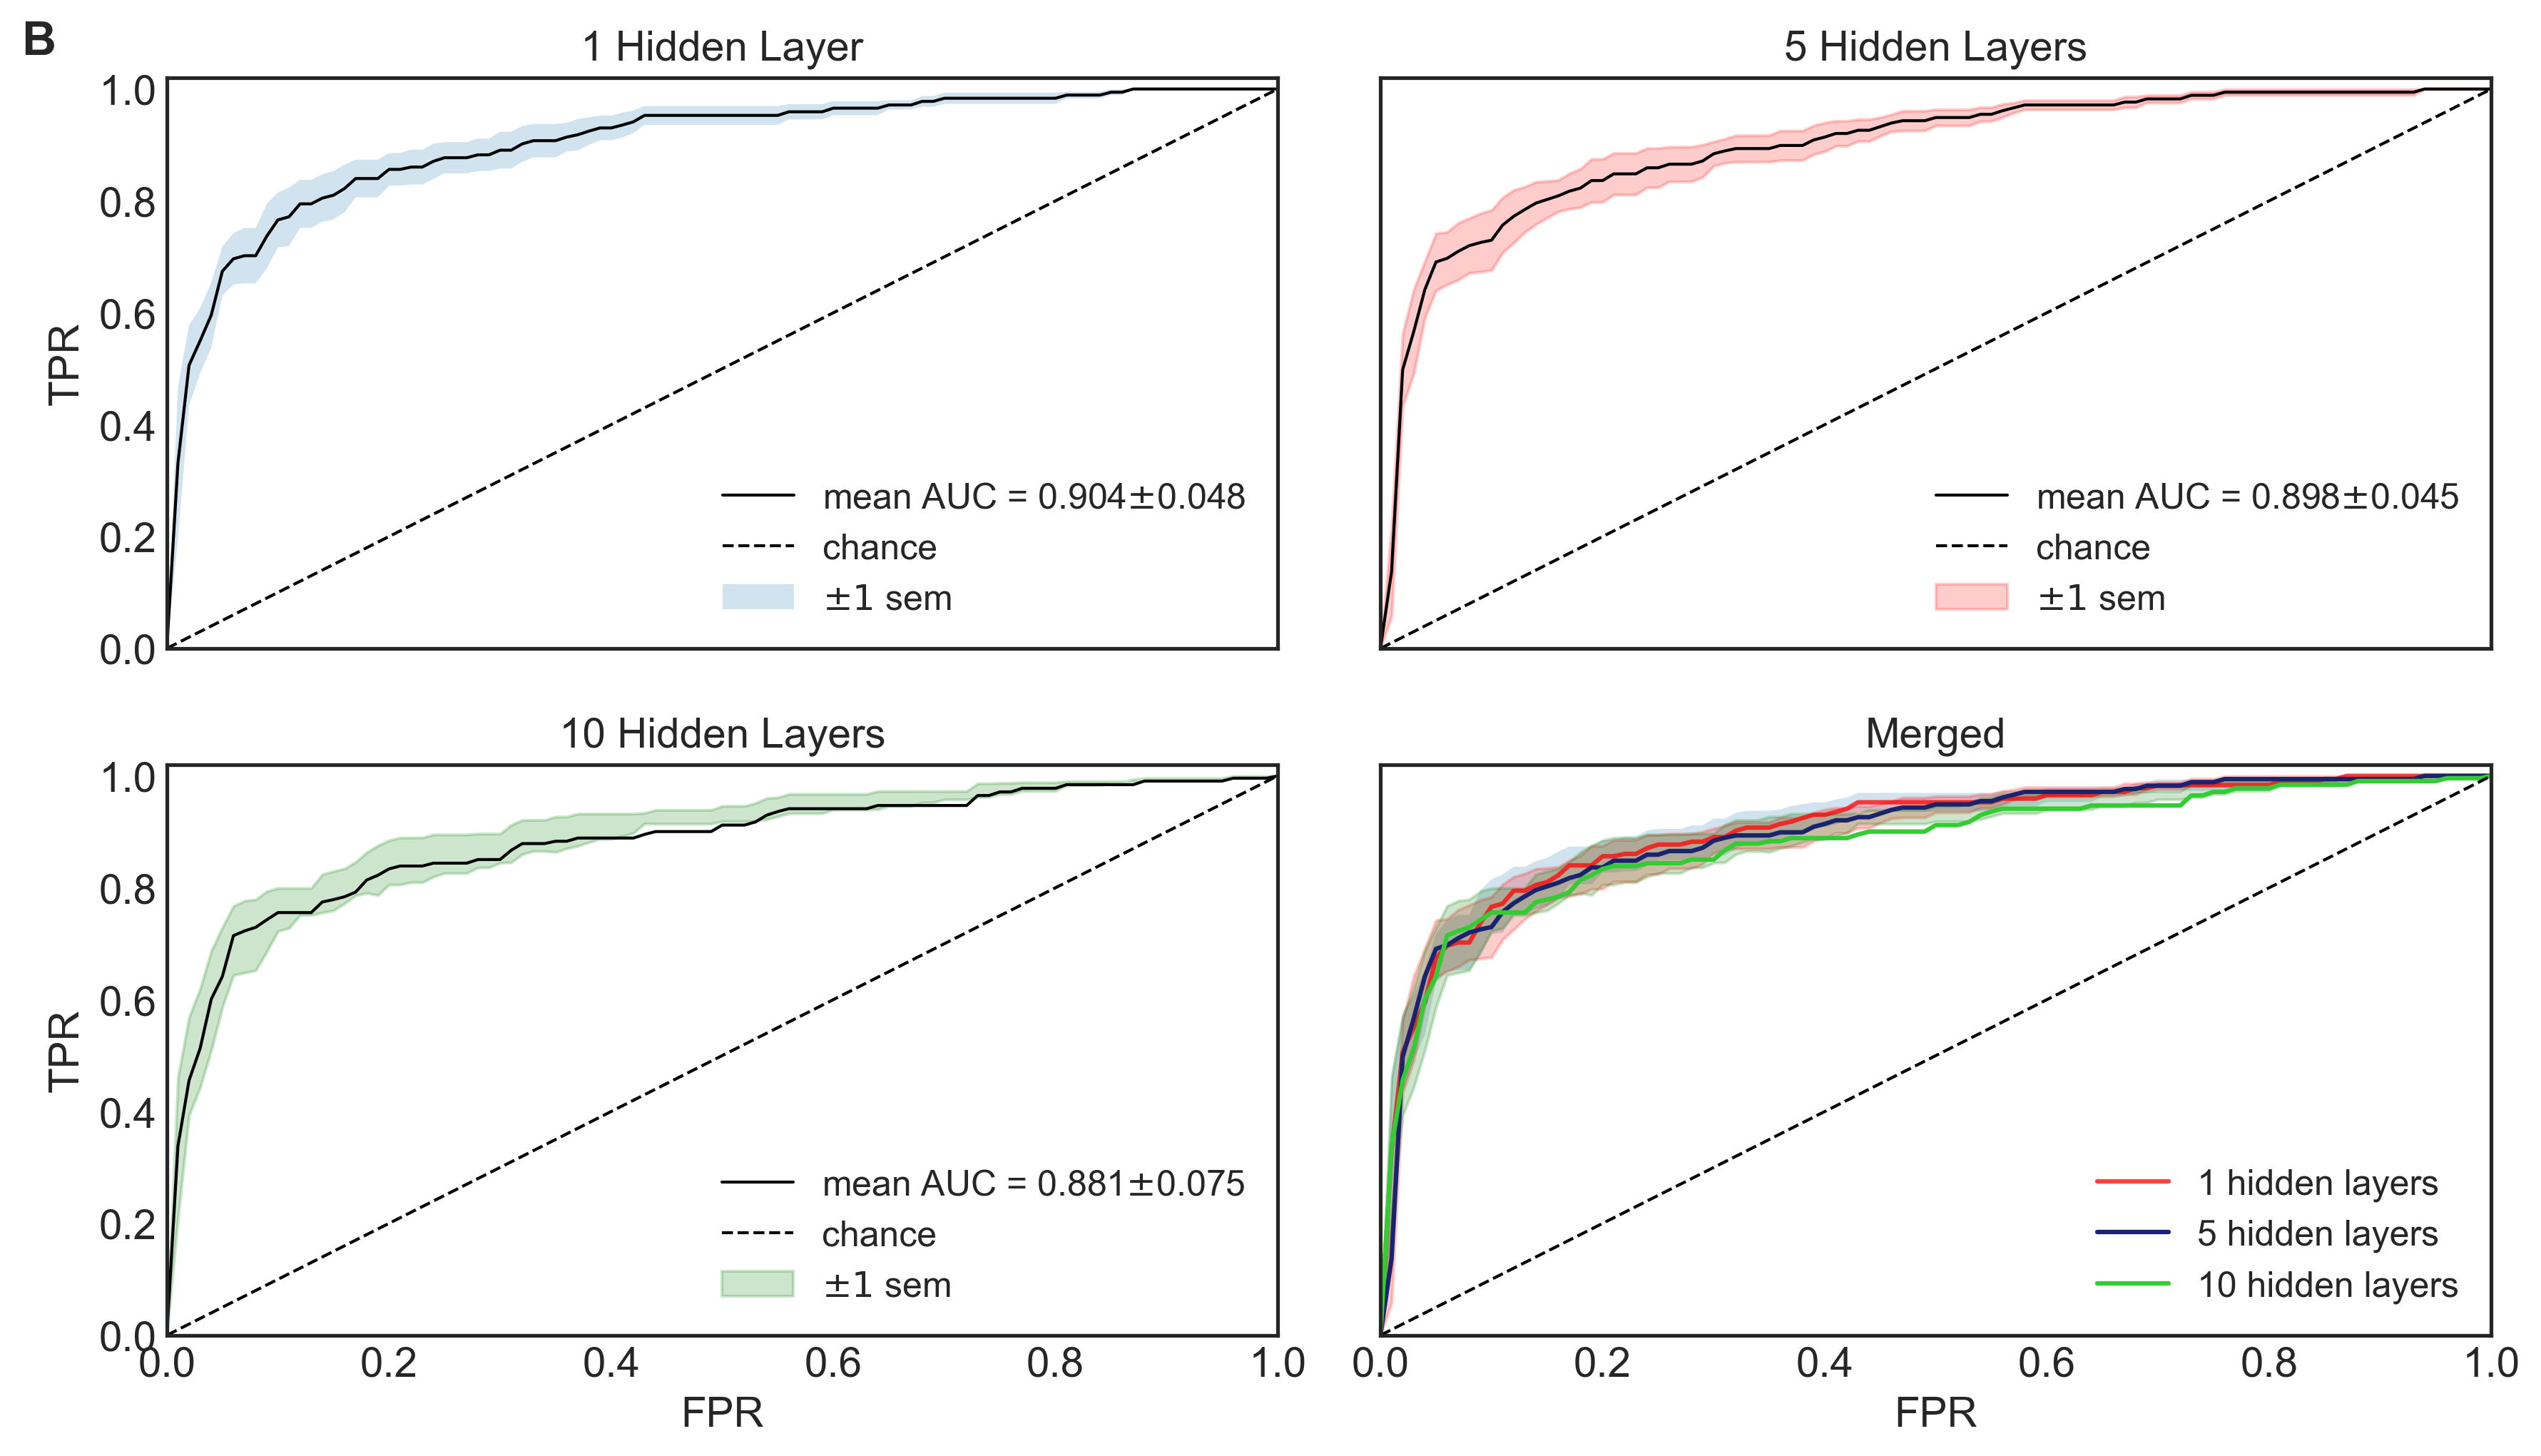

In [46]:
plt.style.use('seaborn-white')

plt.rcParams.update({'font.size': 14})
# combined figure
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 7), dpi=300)

# 1 hidden layer
ax1.plot(base_fpr1, mean_tprs1, 'k', linewidth=1)
ax1.fill_between(base_fpr1, tprs_lower1, tprs_upper1, alpha=0.2)
ax1.plot([0, 1], [0, 1], 'k--', linewidth=1)
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1.02])
ax1.set_title('1 Hidden Layer', fontsize=14)
ax1.set_ylabel('TPR', fontsize=14)
ax1.set_xlabel('FPR', fontsize=14)
ax1.legend(['mean AUC = ' + str(round(auc1, 3)) + '$\pm$' + str(round(np.mean(std1), 3)),
            'chance', '$\pm 1$ sem'],
           fontsize=12, loc='lower right')
ax1.text(-.1, 1.1, 'B', transform=ax1.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

# 5 hidden layers
ax2.plot(base_fpr5, mean_tprs5, color='k', linewidth=1)
ax2.fill_between(base_fpr5, tprs_lower5, tprs_upper5, alpha=0.2, color='r')
ax2.plot([0, 1], [0, 1], 'k--', linewidth=1)
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1.02])
ax2.set_title('5 Hidden Layers', fontsize=14)
ax2.set_ylabel('TPR', fontsize=14)
ax2.set_xlabel('FPR', fontsize=14)
ax2.legend(['mean AUC = ' + str(round(auc5, 3)) + '$\pm$' + str(round(np.mean(std5), 3)),
            'chance', '$\pm 1$ sem'],
           fontsize=12, loc='lower right')

# 10 hidden layers
ax3.plot(base_fpr10, mean_tprs10, color='k', linewidth=1)
ax3.fill_between(base_fpr10, tprs_lower10, tprs_upper10, alpha=0.2, color='g')
ax3.plot([0, 1], [0, 1], 'k--', linewidth=1)
ax3.set_xlim([0, 1])
ax3.set_ylim([0, 1.02])
ax3.set_title('10 Hidden Layers', fontsize=14)
ax3.set_ylabel('TPR', fontsize=14)
ax3.set_xlabel('FPR', fontsize=14)
ax3.legend(['mean AUC = ' + str(round(auc10, 3)) + '$\pm$' + str(round(np.mean(std10), 3)),
            'chance', '$\pm 1$ sem'],
           fontsize=12, loc='lower right')

# merged
## 1
ax4.plot(base_fpr1, mean_tprs1, '#ff0000', linewidth=1.5, alpha=0.75)
ax4.fill_between(base_fpr1, tprs_lower1, tprs_upper1, alpha=0.2)
## 5
ax4.plot(base_fpr5, mean_tprs5, '#1a236e', linewidth=1.5, alpha=1)
ax4.fill_between(base_fpr5, tprs_lower5, tprs_upper5, alpha=0.2, color='r')
## 10
ax4.plot(base_fpr10, mean_tprs10, '#32CD32', linewidth=1.5, alpha=1)
ax4.fill_between(base_fpr10, tprs_lower10, tprs_upper10, alpha=0.2, color='g')
ax4.plot([0, 1], [0, 1], 'k--', linewidth=1)
ax4.set_xlim([0, 1])
ax4.set_ylim([0, 1.02])
ax4.set_title('Merged', fontsize=14)
ax4.set_ylabel('TPR', fontsize=14)
ax4.set_xlabel('FPR', fontsize=14)
ax4.legend(['1 hidden layers', '5 hidden layers', '10 hidden layers'], fontsize=12, loc='lower right')

for ax in fig.get_axes():
    ax.label_outer()
fig.tight_layout()

In [ ]:
fig.savefig('figures/roc_combined.png')